In [1]:
from pylab import plt
plt.style.use('ggplot')
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['font.family'] = 'serif'
import warnings; warnings.simplefilter('ignore')
import scipy.stats as scs
import statsmodels.api as sm
import scipy.optimize as sco
import numpy as np
import pandas as pd
import datetime as dt

pd.options.mode.chained_assignment = None

In [2]:
stock_prices = pd.read_excel("Daily Stock Prices.xlsx", index_col=0, parse_dates=True)

In [3]:
stock_prices.head() 

,A,AA,AAC,AAL,AAME,AAON,AAP,AAPL,AAWW,ABAX,...,ZBB,ZBRA,ZEUS,ZHNE,ZION,ZIOP,ZIXI,ZMH,ZN,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,22.65873,37.46254,150.00,NaN,1.3200,5.922963,40.38,30.57286,38.20,24.90,...,6.00,28.67,33.85,10.7475,13.33,2.95,1.78,60.02,5.896733,12.36
2010-01-05,22.41260,36.29253,150.00,NaN,1.4000,5.751111,40.14,30.62572,40.31,24.92,...,6.10,28.62,33.63,13.0000,13.80,3.05,1.70,61.92,5.806644,12.29
2010-01-06,22.33297,38.18254,144.38,NaN,-1.3550,5.522963,40.49,30.13857,38.63,25.71,...,6.25,28.40,34.95,14.4875,15.00,3.08,1.70,61.90,5.708365,12.68
2010-01-07,22.30401,37.37254,148.02,NaN,1.3200,5.727407,40.48,30.08286,38.95,25.71,...,6.65,27.69,34.50,13.5000,16.68,3.04,2.22,63.32,5.732935,14.66
2010-01-08,22.29677,38.29504,148.02,NaN,1.3911,5.795556,40.64,30.28286,39.27,25.62,...,7.70,27.60,35.58,13.2500,16.41,3.10,2.12,61.99,5.773885,14.73


In [4]:
stock_list_data = pd.read_excel("Final Stock Selections.xlsx")
display(stock_list_data.head())

stock_list = stock_list_data["Ticker"].values.tolist() 

,Ticker
0,AZO
1,ODFL
2,AKRX
3,SHW
4,PII


In [5]:
prices = stock_prices[stock_list]
prices.head()

,AZO,ODFL,AKRX,SHW,PII,MANH,HAIN,UNP,ALXN,VFC,...,COO,SBUX,FNF,DIS,VZ,T,AMZN,MSFT,NFLX,CBS
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,158.03,13.01778,1.87,61.67,22.115,6.2025,8.695,32.695,24.125,18.345,...,37.75,11.525,8.303291,32.07,31.22516,28.58,133.90,30.950,7.640000,14.25
2010-01-05,156.71,13.29778,1.82,60.21,22.125,6.1175,8.695,33.150,23.780,18.695,...,38.19,11.795,7.979945,31.99,31.28146,28.44,134.69,30.960,7.358571,14.18
2010-01-06,155.24,13.54222,1.78,59.42,22.830,6.0250,9.000,33.200,23.840,18.620,...,38.17,11.710,8.150769,31.82,29.94914,27.61,132.25,30.770,7.617143,13.73
2010-01-07,157.30,12.88889,1.72,59.95,22.525,5.9425,9.040,32.905,23.930,18.980,...,38.57,11.680,8.016551,31.83,29.77087,27.30,130.00,30.452,7.485714,14.00
2010-01-08,155.28,13.06667,1.65,60.46,22.595,5.9325,8.960,34.020,23.975,18.880,...,37.95,11.640,8.010449,31.88,29.78963,27.10,133.52,30.660,7.614285,14.15


In [6]:
#prices.to_excel("Chosen Stock Prices.xlsx")

In [7]:
num_assets = len(stock_list)
returns = np.log(prices/prices.shift(1))
future_returns = np.log(prices.shift(-1)/prices)
rf = 0.0021 

start = dt.datetime(2011,1,1)
end = dt.datetime(2014,12,31)

In [8]:
roll_mu = returns.rolling(window=42).mean()*252 
roll_sigma = returns.rolling(window=42).cov()*252

In [9]:
#display(future_returns.head(10))
#display(future_returns.tail(10))

In [10]:
roll_mu_trade = roll_mu[start:end] 
roll_sigma_trade = roll_sigma[start:end] 
future_returns_trade = future_returns[start:end]

dates_trade = roll_mu_trade.index

# We will rebalance portfolio every month 
rebalance_time = 21
n_trade = int(len(roll_mu_trade)/rebalance_time)  

In [36]:
roll_mu_trade = roll_mu_trade.fillna((roll_mu_trade.shift()+ roll_mu_trade.shift(-1))/2)
future_returns_trade = future_returns_trade.fillna( (future_returns_trade.shift()+future_returns_trade.shift(-1)) /2)

In [37]:
weights_trade_raw =np.nan*roll_mu_trade
weights_trade = weights_trade_raw.iloc[::rebalance_time, :]

portfolio_returns=pd.DataFrame(index=dates_trade,columns=['Portfolio Performance']).iloc[::rebalance_time, :]
portfolio_returns.head(2)

,Portfolio Performance
date,
2011-01-03,NaN
2011-02-02,NaN


In [12]:
#weights_trade

In [38]:
def negative_sharpe(weights, mu, Sigma, riskfree):
    weights = np.array(weights)
    pret = np.dot(mu, weights)
    pvol = np.sqrt(np.dot(weights.T, np.dot(Sigma, weights)))
    return -(pret-riskfree)/pvol

cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in range(num_assets))
initial_guess=num_assets * [1. / num_assets,]

In [39]:
for t in range(n_trade): 
    # get an average of the expected returns for each stock for that week
    #display( roll_mu_trade.iloc[t*rebalance_time:(t+1)*rebalance_time])
    mu_week = roll_mu_trade.iloc[t*rebalance_time:(t+1)*rebalance_time].mean() 
    
    # just use the week's last day's covariance matrix since it is a moving average anyways 
    sigma_week = roll_sigma_trade.iloc[(t+1)*rebalance_time*num_assets-num_assets:(t+1)*rebalance_time*num_assets]
    
    parameter_input=(mu_week,sigma_week,rf)
    
    #print(parameter_input)
    
    weights_trade.iloc[t]=sco.minimize(negative_sharpe,initial_guess,args=parameter_input,bounds=bnds,constraints=cons)['x']
    
    #display(weights_trade)
         
    #future_returns_week = future_returns_trade.iloc[t*rebalance_time:(t+1)*rebalance_time].cumsum().iloc[-1]
    future_returns_week = future_returns_trade.iloc[t*rebalance_time:(t+1)*rebalance_time]
    cumulative_week_return_df = (1+ future_returns_week).cumprod() - 1  
    cumulative_future_return = cumulative_week_return_df.iloc[-1]
    
    #display(future_returns_week)
    
    portfolio_returns.iloc[t]=np.dot(weights_trade.iloc[t],cumulative_future_return)
    

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45 entries, 2011-01-03 to 2014-11-03
Data columns (total 2 columns):
Portfolio Performance    45 non-null object
Port_performance         45 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.1+ KB


,Portfolio Performance,Port_performance
date,,
2011-01-03,0.0303331,0.030333
2011-02-02,0.0697271,0.069727
2011-03-04,0.0516089,0.051609
2011-04-04,0.0427892,0.042789
2011-05-04,0.0138983,0.013898


,Port_performance
count,45.000000
mean,0.045857
std,0.028886
min,-0.021211
25%,0.030333
50%,0.048035
75%,0.062091
max,0.109596


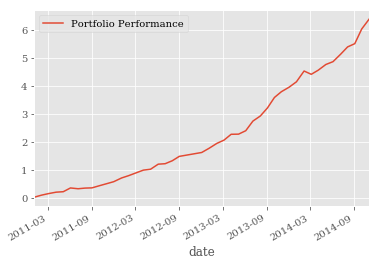

In [42]:
#portfolio_returns.cumsum().plot()

cumulative_portfolio_returns = (1+portfolio_returns).cumprod() - 1 
cumulative_portfolio_returns.plot() 

portfolio_returns.dropna(inplace=True)
portfolio_returns['Port_performance']=pd.to_numeric(portfolio_returns['Portfolio Performance'])
portfolio_returns.info()
display(portfolio_returns.head())
portfolio_returns.describe()

In [44]:
print("Our Portfolio made {}x return in the testing period from 2011 to 2014".format(cumulative_portfolio_returns["Portfolio Performance"].iloc[-1]))

Our Portfolio made 6.395086644531162x return in the testing period from 2011 to 2014


In [17]:
# Out of Sample Testing 

out_sample_all_stock_prices = pd.read_csv('crsp_out_sample_2019spring.csv', parse_dates=['date'])
out_sample_all_prices_sorted = out_sample_all_stock_prices.sort_values(['cik','date'])
pivoted_out_sample_all = out_sample_all_prices_sorted.pivot(index="date",columns="ticker",values="adj_prc")
prices_out = pivoted_out_sample_all[stock_list]
prices_out.tail()

ticker,AZO,ODFL,AKRX,SHW,PII,MANH,HAIN,UNP,ALXN,VFC,...,COO,SBUX,FNF,DIS,VZ,T,AMZN,MSFT,NFLX,CBS
date,,,,,,,,,,,,,,,,,,,,,
2016-12-23,795.82,86.88,21.71,272.30,80.22,53.58,39.34,105.18,127.19,53.30,...,175.43,57.01,24.75303,105.15,53.68,42.73,760.59,63.24,125.59,64.67
2016-12-27,803.57,87.20,21.48,272.38,80.55,53.97,39.83,105.71,126.06,53.78,...,177.44,56.86,24.84762,105.17,53.64,42.65,771.40,63.28,128.35,64.85
2016-12-28,795.89,85.68,21.02,270.30,80.82,53.44,39.52,104.76,123.73,53.81,...,175.34,56.35,24.58569,104.30,53.44,42.52,772.13,62.99,125.89,64.50
2016-12-29,798.49,86.23,21.15,271.13,81.37,53.58,39.59,104.42,123.63,53.63,...,175.49,56.32,24.48382,104.56,53.74,42.66,765.15,62.90,125.33,64.50
2016-12-30,789.79,85.79,21.83,268.74,82.39,53.03,39.03,103.68,122.35,53.35,...,174.93,55.52,24.70938,104.22,53.38,42.53,749.87,62.14,123.80,63.62


In [18]:
returns_out = np.log(prices_out/prices_out.shift(1))
future_returns_out = np.log(prices_out.shift(-1)/prices_out)                            

In [19]:
roll_mu_out = returns_out.rolling(window=42).mean()*252
roll_sigma_out = returns_out.rolling(window=42).cov()*252

In [20]:
rf_out = 0.0014

dates_trade_out = roll_mu_out.index 
n_trade_out = int(len(roll_mu_out)/rebalance_time)

weights_trade_out = np.nan*roll_mu_out 
portfolio_returns_out = pd.DataFrame(index=dates_trade_out,columns=["Portfolio Performance"]).iloc[::rebalance_time,:]

In [21]:
for t in range(n_trade_out):
    mu_week = roll_mu_out.iloc[t*rebalance_time:(t+1)*rebalance_time].mean() 
    
    # just use the week's last day's covariance matrix since it is a moving average anyways 
    sigma_week = roll_sigma_out.iloc[(t+1)*rebalance_time*num_assets-num_assets:(t+1)*rebalance_time*num_assets]
    
    parameter_input=(mu_week,sigma_week,rf_out)
    weights_trade_out.iloc[t]=sco.minimize(negative_sharpe,initial_guess,args=parameter_input,bounds=bnds,constraints=cons)['x']
    
    #future_returns_out_week = future_returns_out.iloc[t*rebalance_time:(t+1)*rebalance_time].cumsum().iloc[-1]
    
    future_returns_out_week = future_returns_out.iloc[t*rebalance_time:(t+1)*rebalance_time]
    cumulative_week_out_return_df = (1+ future_returns_out_week).cumprod() - 1  
    cumulative_future_return_out = cumulative_week_out_return_df.iloc[-1]
    
    portfolio_returns_out.iloc[t]=np.dot(weights_trade_out.iloc[t],cumulative_future_return_out)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19 entries, 2015-03-05 to 2016-11-01
Data columns (total 2 columns):
Portfolio Performance    19 non-null object
Port_performance         19 non-null float64
dtypes: float64(1), object(1)
memory usage: 456.0+ bytes


,Portfolio Performance,Port_performance
date,,
2015-03-05,0.0500982,0.050098
2015-04-06,0.025664,0.025664
2015-05-05,0.0585683,0.058568
2015-08-04,-0.0110132,-0.011013
2015-09-02,0.0149296,0.014930


,Port_performance
count,19.000000
mean,0.033546
std,0.027801
min,-0.011013
25%,0.017940
50%,0.027597
75%,0.048081
max,0.105989


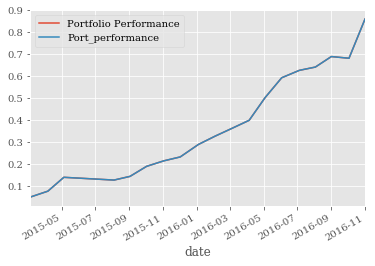

In [26]:
#portfolio_returns_out.cumsum().plot()

cumulative_portfolio_returns_out = (1+portfolio_returns_out).cumprod() - 1 
cumulative_portfolio_returns_out.plot() 

portfolio_returns_out.dropna(inplace=True)
#portfolio_returns_out['Port_performance']=pd.to_numeric(portfolio_returns_out['Portfolio Performance'])
portfolio_returns_out.info()
display(portfolio_returns_out.head())
portfolio_returns_out.describe()

In [27]:
print("Our Portfolio in out of sample testing made {}x return from beginning of 2015 to end 2016".format(cumulative_portfolio_returns_out['Portfolio Performance'].iloc[-1]))

Our Portfolio in out of sample testing made 0.8598471294627796x return from beginning of 2015 to end 2016


In [24]:
rf_out_of_sample_reporting = 0.0016 # monthly 